In [1]:
import numpy as np
import cvxopt
import struct
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors

### Control_horizon=1, planning_horizon=1

In [33]:
del_t = 0.1
v_init = 10
w_init = 0.1
a_max = 10
alpha_min = -0.5
alpha_max = 0.5

class agent:
    def __init__(self,rad,start,goal,theta,vmax,wmax):
        self.rad = rad
        self.xpath = []
        self.ypath = []
        self.vplot = []
        self.wplot = []
        self.time = 0
        self.goal = goal
        self.theta = theta
        self.v = v_init
        self.w = w_init
        self.pos = start
        self.vmax = vmax
        self.wmax = wmax
        
    def __str__(self):
        return (str(self.time)+" "+str(self.theta)+" "+str(self.v)+" "+str(self.w)+" "+str(self.pos))    
            

    def opt_traj(self):
        self.visualize_traj()
        print ("start v: ",self.v,"start w: ",self.w)
        while (np.linalg.norm(self.pos-self.goal)>0.7):
            x_new = self.pos[0] + self.v*del_t*np.cos(self.theta+self.w*del_t)
            y_new = self.pos[1] + self.v*del_t*np.sin(self.theta+self.w*del_t)
            self.theta += self.w*del_t
            self.xpath.append(x_new)
            self.ypath.append(y_new)
            self.pos = [x_new,y_new]
            theta_new = self.theta
            v_new = self.v
            w_new = self.w
            v_orig = self.v
            w_orig = self.w
            diff_v = 999
            diff_w = 999
            tol = 1e-1
            
            while (np.linalg.norm(np.array([diff_w,diff_v])**2)>tol):
                w_guess = self.w
                v_guess = self.v
                x = del_t*np.cos(self.theta+w_guess*del_t)
                a = -v_guess*del_t**2*np.sin(self.theta+w_guess*del_t)
                y = del_t*np.sin(self.theta+w_guess*del_t)
                b = v_guess*del_t**2*np.cos(self.theta+w_guess*del_t)
                kx = self.pos[0]+v_guess*del_t**2*w_guess*np.sin(self.theta+w_guess*del_t) - self.goal[0]
                ky = self.pos[1]-v_guess*del_t**2*w_guess*np.cos(self.theta+w_guess*del_t) - self.goal[1]
                arrx = np.array([[x],[a]])
                arry = np.array([[y],[b]])
                p_mat = 2*(np.matmul(arrx,arrx.T)+np.matmul(arry,arry.T))
                P = cvxopt.matrix(p_mat,tc='d')
                q_mat = 2*(kx*arrx+ky*arry)
                Q = cvxopt.matrix(q_mat,tc='d')
                g_mat = np.array([[0,-1],[-1,0],[1,0],[0,1],[1,0],[-1,0],[0,1],[0,-1]])
                h = cvxopt.matrix(np.array([self.wmax,0,self.vmax,self.wmax,v_guess+5,-(v_guess-5),w_guess+0.1,-(w_guess-0.1)]),tc='d')
                g = cvxopt.matrix(g_mat,tc='d')
                sol = cvxopt.solvers.qp(P,Q,g,h,options={'show_progress': False})
                v_new = sol['x'][0] #vd
                w_new = sol['x'][1] #wd

                diff_v = v_new - self.v
                diff_w = w_new - self.w
                print (diff_v,diff_w)
                self.v = v_new #vd+vi
                self.w = w_new #wd+wi

            print ("#####################End of Optimization######################")
            print (self)
            self.time+=1
            self.visualize_traj()

             
    def visualize_traj(self):
        figure = plt.figure()
#         print (self.pos)
        print ("Theta: ",self.theta)
        ax = figure.add_subplot(1,1,1)
        robot = matplotlib.patches.Rectangle(
            (self.pos[0]-self.rad*np.sqrt(2)*np.cos(self.theta+np.pi/4),self.pos[1]-self.rad*np.sqrt(2)*np.sin(self.theta+np.pi/4)),
            height = self.rad*2,
            width = self.rad*2,
            angle = self.theta*180/np.pi,
            edgecolor='black',
            linewidth=1.0,
            animated=True,
            alpha=1,
            zorder=2)
        ax.add_patch(robot)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="red", markersize =15,linewidth=3.0)
        ax.plot(self.xpath,self.ypath,'b-')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 100.0)
        ax.set_ylim(-10.0, 100.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure
    


In [37]:
bot = agent(2,np.array([0,0]),np.array([80,50]),np.pi/2,20,0.5)
bot.opt_traj()

Theta:  1.5707963267948966
start v:  10 start w:  0.1
5.000000003192696 -0.0999999122265636
4.999999627382866 -0.09999988231174561
3.3631284424018304e-08 -0.09999982092591811
#####################End of Optimization######################
0 1.5807963267948966 19.999999664206847 -0.19999961546422731 [-0.009999833334166612, 0.9999500004166653]
Theta:  1.5807963267948966
5.040142525558622e-08 -0.09999984772272777
#####################End of Optimization######################
1 1.5607963652484738 19.999999714608272 -0.2999994631869551 [0.009999756095071479, 2.9998499684414166]
Theta:  1.5607963652484738
6.19865474504877e-08 -0.09999994964590159
#####################End of Optimization######################
2 1.5307964189297782 19.99999977659482 -0.39999941283285667 [0.08997823920471247, 4.998250160615845]
Theta:  1.5307964189297782
-1.343707360490498e-06 -0.0999999925232471
#####################End of Optimization######################
3 1.4907964776464926 19.99999843288746 -0.4999994053561

-1.1324348747621116e-07 0.09999976710783864
#####################End of Optimization######################
36 0.12076620352567705 19.99999985062943 0.2999503104306263 [47.34284425027735, 43.80217132166577]
Theta:  0.12076620352567705
-5.56467377066383e-07 0.0999881305749592
#####################End of Optimization######################
37 0.1507612345687397 19.999999294162052 0.3999384410055855 [49.320158303488, 44.102552871078245]
Theta:  0.1507612345687397
5.474297246621518e-07 -0.09993471129898795
#####################End of Optimization######################
38 0.19075507866929825 19.999999841591777 0.30000372970659756 [51.28388093791634, 44.481753520733086]
Theta:  0.19075507866929825
-2.0661394017906787e-07 -0.0999901855308131
#####################End of Optimization######################
39 0.22075545163995802 19.999999634977836 0.20001354417578446 [53.235345540347566, 44.91968712539781]
Theta:  0.22075545163995802
-5.213818248250845e-07 -0.09999418241871642
####################

### Control_horizon = 1, planning_horizon = p

In [76]:
del_t = 0.1
planning_horizon = 10
v_guess = 20*np.ones((planning_horizon))
w_guess = 0.1*np.ones((planning_horizon))
v_init = v_guess[0]
w_init = w_guess[0]
a_max = 10
alpha_min = -0.5
alpha_max = 0.5

class mpc_agent:
    def __init__(self,rad,start,goal,theta,vmax,wmax):
        self.rad = rad
        self.xpath = []
        self.ypath = []
        self.vplot = []
        self.wplot = []
        self.time = 0
        self.goal = goal
        self.theta = theta
        self.v = v_init
        self.w = w_init
        self.v_guess = v_guess
        self.w_guess = w_guess
        self.prev_v = v_guess
        self.prev_w = w_guess
        self.pos = start
        self.vmax = vmax
        self.wmax = wmax
        self.vlist = []
        self.wlist = []
        plt.ion()
        self.dummy_x = np.array([])
        self.dummy_y = np.array([])
        
        
    def __str__(self):
        return (str(self.time)+" "+str(self.theta)+" "+str(self.v)+" "+str(self.w)+" "+str(self.pos))    
            
    def p_constructor(self):
        wg = np.cumsum(self.w_guess)
        p_theta = self.theta+wg*del_t
        
        xs = del_t*np.cos(p_theta)
        qx = np.sin(p_theta)
        bs = -self.v_guess*del_t**2*qx
        brev = bs[::-1]
        dterms = np.cumsum(brev)
        dterms = dterms[::-1]
        arrx = np.concatenate((xs, dterms), axis=None)
        ksx = -bs*self.w_guess
        kx = np.sum(ksx) + self.pos[0] - self.goal[0]
        
        ys = del_t*np.sin(p_theta)
        qy = np.cos(p_theta)
        by = self.v_guess*del_t**2*qy
        byrev = by[::-1]
        dyterms = np.cumsum(byrev)
        dyterms = dyterms[::-1]
        arry = np.concatenate((ys, dyterms), axis=None)
        ksy = -by*self.w_guess
        ky = np.sum(ksy) + self.pos[1] - self.goal[1]
        
        
        return arrx,arry,kx,ky
        
    def opt_traj(self):
        self.visualize_traj()
        print ("start v: ",self.v,"start w: ",self.w)
        
        while (np.linalg.norm(self.pos-self.goal)>0.7):
            x_new = self.pos[0] + self.v*del_t*np.cos(self.theta+self.w*del_t)
            y_new = self.pos[1] + self.v*del_t*np.sin(self.theta+self.w*del_t)
            self.theta += self.w*del_t
            self.xpath.append(x_new)
            self.ypath.append(y_new)
            self.pos = [x_new,y_new]
            theta_new = self.theta
            v_new = self.v
            w_new = self.w
            diff_v = 999
            diff_w = 999
            tol = 1e-1
            
            while (np.linalg.norm(np.array([diff_w,diff_v])**2)>tol):
                arrx,arry,kx,ky = self.p_constructor()
                arrx = arrx.reshape((-1,1))
                arry = arry.reshape((-1,1))
                p_mat = 2*(np.matmul(arrx,arrx.T)+np.matmul(arry,arry.T))
                P = cvxopt.matrix(p_mat,tc='d')
                q_mat = 2*(kx*arrx+ky*arry)
                Q = cvxopt.matrix(q_mat,tc='d')
                g_mat = np.eye(2*planning_horizon)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
                g_mat = np.concatenate((g_mat,np.eye(2*planning_horizon)),axis=0)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
                h_mat = np.concatenate((self.vmax*np.ones(planning_horizon),self.wmax*np.ones(planning_horizon),np.zeros(planning_horizon),self.wmax*np.ones(planning_horizon),self.v_guess+5,self.w_guess+0.1,-(self.v_guess-5),-(self.w_guess-0.1)),axis=None)
                h = cvxopt.matrix(h_mat,tc='d')
                g = cvxopt.matrix(g_mat,tc='d')

                sol = cvxopt.solvers.qp(P,Q,g,h,options={'show_progress': False})
                v_new = sol['x'][:planning_horizon] #vd
                w_new = sol['x'][planning_horizon:] #wd
                diff_v = v_new[0] - self.v
                diff_w = w_new[0] - self.w

                self.v = v_new[0]
                self.w = w_new[0]
                self.prev_v = np.array(v_new)
                self.prev_w = np.array(w_new)
                self.v_guess = self.prev_v[1:]
                self.v_guess = np.concatenate((self.v_guess,np.array([[self.v]])),axis=0)
                self.v_guess = self.v_guess.reshape((-1,))
                self.w_guess = self.prev_w[1:]
                self.w_guess = np.concatenate((self.w_guess,np.array([[self.w]])),axis=0)
                self.w_guess = self.w_guess.reshape((-1,))
                
            print ("##########End of Optimization#############")
            print ("new v: ",self.v,"new w: ",self.w)
            print ("Opti complete")
            print (self)
            self.time+=1
            self.visualize_traj()

             
    def visualize_traj(self):
        figure = plt.figure()
        print ("Theta: ",self.theta)
        ax = figure.add_subplot(1,1,1)
        robot = matplotlib.patches.Rectangle(
            (self.pos[0]-self.rad*np.sqrt(2)*np.cos(self.theta+np.pi/4),self.pos[1]-self.rad*np.sqrt(2)*np.sin(self.theta+np.pi/4)),
            height = self.rad*2,
            width = self.rad*2,
            angle = self.theta*180/np.pi,
            edgecolor='black',
            linewidth=1.0,
            animated=True,
            alpha=1,
            zorder=2)
        ax.add_patch(robot)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="red", markersize =15,linewidth=3.0)
        ax.plot(self.xpath,self.ypath,'b-')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 100.0)
        ax.set_ylim(-10.0, 100.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure
    


In [78]:
bot1 = mpc_agent(2,np.array([0,0]),np.array([60,90]),np.pi/4,30,0.5)
bot1.opt_traj()

Theta:  0.7853981633974483
start v:  20.0 start w:  0.1
##########End of Optimization#############
new v:  29.99999994982747 new w:  0.39999864017786496
Opti complete
0 0.7953981633974483 29.99999994982747 0.39999864017786496 [1.400000952361581, 1.4282847522068791]
Theta:  0.7953981633974483
##########End of Optimization#############
new v:  29.99999925492052 new w:  0.4999947378726051
Opti complete
1 0.8353980274152348 29.99999925492052 0.4999947378726051 [3.412648668497223, 3.652975548841429]
Theta:  0.8353980274152348
##########End of Optimization#############
new v:  29.999999946493105 new w:  0.3999953597596147
Opti complete
2 0.8853975012024954 29.999999946493105 0.3999953597596147 [5.3115940793141005, 5.97547546911911]
Theta:  0.8853975012024954
##########End of Optimization#############
new v:  29.999999173812864 new w:  0.499968885136218
Opti complete
3 0.9253970371784569 29.999999173812864 0.499968885136218 [7.116146464554994, 8.372054417707549]
Theta:  0.9253970371784569
###

##########End of Optimization#############
new v:  10.948371996897206 new w:  -0.0009905989734834213
Opti complete
35 1.012554610939872 10.948371996897206 -0.0009905989734834213 [54.193440316853774, 80.71828013920374]
Theta:  1.012554610939872
##########End of Optimization#############
new v:  9.853509814738917 new w:  -0.0011169806973223958
Opti complete
36 1.0124555510425237 9.853509814738917 -0.0011169806973223958 [54.77346281942475, 81.64685021751541]
Theta:  1.0124555510425237
##########End of Optimization#############
new v:  8.868158632049067 new w:  -0.0010038004422876956
Opti complete
37 1.0123438529727915 8.868158632049067 -0.0010038004422876956 [55.29557509226169, 82.48250285542461]
Theta:  1.0123438529727915
##########End of Optimization#############
new v:  7.981348204432672 new w:  -0.0008301174982519197
Opti complete
38 1.0122434729285628 7.981348204432672 -0.0008301174982519197 [55.76555161934766, 83.23454304000259]
Theta:  1.0122434729285628
##########End of Optimizati

### Planning horizon = p, control horizon = c with obstacle

In [754]:
del_t = 0.1
planning_horizon = 40
control_horizon = 5
v_guess = np.ones((planning_horizon))
w_guess = 0.1*(np.random.rand(planning_horizon)-0.5)
print (v_guess,w_guess)

v_init = v_guess
w_init = w_guess
a_max = 5
a_min = -3
obst_rad = 2
obst_pos = [40,0]
alpha_min = -0.2
alpha_max = 0.2

class multi_mpc_agent:
    def __init__(self,rad,start,goal,theta,vmax,wmax):
        self.rad = rad
        self.obst_rad = obst_rad
        self.obst = obst_pos
        self.xpath = []
        self.ypath = []
        self.vplot = []
        self.wplot = []
        self.time = 0
        self.goal = goal
        self.theta = theta
        self.v = v_init
        self.w = w_init
        self.v_guess = v_guess
        self.w_guess = w_guess
        self.prev_v = v_guess
        self.prev_w = w_guess
        self.pos = start
        self.vmax = vmax
        self.wmax = wmax
        self.amax = a_max
        self.amin = a_min
        self.alphamin = alpha_min
        self.alphamax = alpha_max
        
        plt.ion()
        self.dummy_x = np.array([])
        self.dummy_y = np.array([])
        self.vlast = 1
        self.wlast = 0.1
        self.vlist = []
        self.wlist = []
        
    def __str__(self):
        return (str(self.time)+" "+str(self.theta)+" "+str(self.pos))    
            
    def p_constructor(self):
        wg = np.cumsum(self.w_guess)
        p_theta = self.theta+wg*del_t #net theta
        
        #overall row structure is [x y z a+b+c b+c c]
        xs = del_t*np.cos(p_theta) #v coefficients (i.e, x,y,z)
        qx = np.sin(p_theta)
        bs = -self.v_guess*del_t**2*qx #w coefficients (i.e. a,b,c)
        brev = bs[::-1] #this gives [c,b,a]
        dterms = np.cumsum(brev) #this gives [c,b+c,a+b+c]
        dterms = dterms[::-1] #this gives [a+b+c,b+c,c]
        arrx = np.concatenate((xs, dterms), axis=None)
        ksx = -dterms*self.w_guess 
        kx = np.sum(ksx) + self.pos[0] - self.goal[0] 
        
        
        ys = del_t*np.sin(p_theta)
        qy = np.cos(p_theta)
        by = self.v_guess*del_t**2*qy
        byrev = by[::-1]
        dyterms = np.cumsum(byrev)
        dyterms = dyterms[::-1]
        arry = np.concatenate((ys, dyterms), axis=None)
        ksy = -dyterms*self.w_guess 
        ky = np.sum(ksy) + self.pos[1] - self.goal[1] 
        
        
        
        return arrx,arry,kx,ky
    
    def obst_constraint(self,i):
        
        wg = np.cumsum(self.w_guess[:i])
        p_theta = self.theta+wg*del_t
        
        xs = del_t*np.cos(p_theta)
        qx = np.sin(p_theta)
        bs = -self.v_guess[:i]*del_t**2*qx
        xk = 2*((self.pos[0] - self.obst[0]) + np.sum(self.v_guess[:i]*del_t*np.cos(p_theta)))
        brev = bs[::-1]
        dterms = np.cumsum(brev)
        dterms = dterms[::-1]
        arrx = np.concatenate((xs, dterms), axis=None)
        ksx = dterms*self.w_guess[:i]
        kx = -np.sum(ksx) - np.sum(self.v_guess[:i]*del_t*np.cos(p_theta))
        nx = np.sum(xk*kx)
        consx = (self.pos[0]+np.sum(self.v_guess[:i]*del_t*np.cos(p_theta))-self.obst[0])**2
        
        ys = del_t*np.sin(p_theta)
        qy = np.cos(p_theta)
        by = self.v_guess[:i]*del_t**2*qy
        yk = 2*((self.pos[1] - self.obst[1]) + np.sum(self.v_guess[:i]*del_t*np.sin(p_theta)))
        byrev = by[::-1]
        dyterms = np.cumsum(byrev)
        dyterms = dyterms[::-1]
        arry = np.concatenate((ys, dyterms), axis=None)
        ksy = dyterms*self.w_guess[:i]
        ky = -np.sum(ksy) - np.sum(self.v_guess[:i]*del_t*np.sin(p_theta))
        ny = np.sum(yk*ky)
        consy = (self.pos[1]+np.sum(self.v_guess[:i]*del_t*np.sin(p_theta))-self.obst[1])**2
        
        px = xk*arrx
        py = yk*arry
        
        obsx = np.concatenate(((px[:i]+py[:i]),np.zeros(planning_horizon-i),(px[i:]+py[i:]),np.zeros(planning_horizon-i)),axis=None)
        
        return (obsx,nx,ny,consx,consy)
    
    def is_pos_def(self,x):
        return np.all(np.linalg.eigvals(x) >= 0)

    def opt_traj(self):
        self.visualize_traj()
        print ("start v: ",self.v,"start w: ",self.w)
        
        while (np.linalg.norm(self.pos-self.goal)>0.6):
            v_new = self.v
            w_new = self.w
            diff_v = 999
            diff_w = 999
            tol = 1e-1
            
            while (np.linalg.norm(np.array([diff_w,diff_v])**2)>tol):
                arrx,arry,kx,ky = self.p_constructor()
                arrx = arrx.reshape((-1,1))
                arry = arry.reshape((-1,1))
                p_mat = 2*(np.matmul(arrx,arrx.T)+np.matmul(arry,arry.T))
                
                p_mat += 1e-6*np.eye(p_mat.shape[0])
                P = cvxopt.matrix(p_mat,tc='d')
                q_mat = 2*(kx*arrx+ky*arry) 
                Q = cvxopt.matrix(q_mat,tc='d')
                g_mat = np.eye(2*planning_horizon)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
                g_mat = np.concatenate((g_mat,np.eye(2*planning_horizon)),axis=0)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
                acc = np.diff(np.eye(2*planning_horizon+1))
                acc_const = np.concatenate((acc[1:planning_horizon],acc[planning_horizon+1:-1]),axis=0)
                g_mat = np.concatenate((g_mat,acc_const),axis=0)
                g_mat = np.concatenate((g_mat,-acc_const),axis=0)
                h_mat = np.concatenate((self.vmax*np.ones(planning_horizon),self.wmax*np.ones(planning_horizon),np.zeros(planning_horizon),
                                        self.wmax*np.ones(planning_horizon),self.v_guess+2,self.w_guess+0.05,-(self.v_guess-2),
                                        -(self.w_guess-0.05),self.amax*del_t*np.ones((planning_horizon-1,1)),
                                         self.alphamax*del_t*np.ones((planning_horizon-1,1)),
                                        -self.amin*del_t*np.ones((planning_horizon-1,1)),
                                        -self.alphamin*del_t*np.ones((planning_horizon-1,1))),axis=None)
                a1 = np.concatenate((np.array([1]),np.zeros(2*planning_horizon-1)),axis=None)
                a2 = np.concatenate((np.zeros(planning_horizon),np.array([1]),np.zeros(planning_horizon-1)),axis=None)
                a_mat = np.array((a1, a2))

                A = cvxopt.matrix(a_mat,tc='d')
                b = cvxopt.matrix(np.concatenate((self.vlast,self.wlast),axis=None),tc='d')
                ##For collision avoidance
                if ((self.pos[0]-self.obst[0])<5 or (self.pos[1]-self.obst[1])<5):
                    for i in range(planning_horizon):
                        obst_xk,obst_nx,obst_ny,consx,consy = self.obst_constraint(i+1)
                        g_mat = np.concatenate((g_mat,-np.array([obst_xk])),axis=0)
                        h_mat = np.concatenate((h_mat,-(-consx-consy+(self.obst_rad+self.rad+2)**2+0.5-obst_nx-obst_ny)),axis=None)

                h = cvxopt.matrix(h_mat,tc='d')
                g = cvxopt.matrix(g_mat,tc='d')
                init_vals = np.concatenate((self.v_guess,self.w_guess),axis=None)

                sol = cvxopt.solvers.qp(P,Q,g,h,A,b,options={'show_progress': False})
                v_new = sol['x'][:planning_horizon] #vd
                w_new = sol['x'][planning_horizon:] #wd

                diff_v = np.linalg.norm(np.array(v_new) - self.v)
                diff_w = np.linalg.norm(np.array(w_new) - self.w)
                self.v = v_new
                self.w = w_new
                self.prev_v = np.array(v_new)
                self.prev_w = np.array(w_new)
                
                self.v_guess = self.prev_v
                self.v_guess = self.v_guess.reshape((-1,))
                self.w_guess = self.prev_w
                self.w_guess = self.w_guess.reshape((-1,))
            
                
            print ("##########End of Optimization#############")
            print ("Opti complete")
        
            dummy_x = []
            dummy_y = []
            temp_x = self.pos[0]
            temp_y = self.pos[1]
            temp_theta = self.theta
            for i in range(planning_horizon):
                temp_x = temp_x + self.v[i]*del_t*np.cos(temp_theta+self.w[i]*del_t)
                temp_y = temp_y + self.v[i]*del_t*np.sin(temp_theta+self.w[i]*del_t)
                temp_theta += self.w[i]*del_t
                dummy_x.append(temp_x)
                dummy_y.append(temp_y)

            self.dummy_x = np.array(dummy_x)
            self.dummy_y = np.array(dummy_y)
            
            for i in range(control_horizon):
                x_new = self.pos[0] + self.v[i]*del_t*np.cos(self.theta+self.w[i]*del_t)
                y_new = self.pos[1] + self.v[i]*del_t*np.sin(self.theta+self.w[i]*del_t)
                self.vlist.append(self.v[i])
                self.wlist.append(self.w[i])
                self.theta += self.w[i]*del_t
                self.xpath.append(x_new)
                self.ypath.append(y_new)
                self.pos = [x_new,y_new]
                print (self)
                self.time+=1
                self.visualize_traj()
            self.vlast = self.v[control_horizon-1]
            self.wlast = self.w[control_horizon-1]
            print ("#####End of control horizon#####")
            self.v_guess = self.v[control_horizon:planning_horizon]
            self.v_guess = np.concatenate((self.v_guess,self.v[planning_horizon-1]*np.ones([control_horizon,1])),axis=0)
            self.v_guess = self.v_guess.reshape((-1,))
            self.w_guess = self.w[control_horizon:planning_horizon]
            self.w_guess = np.concatenate((self.w_guess,self.w[planning_horizon-1]*np.ones([control_horizon,1])),axis=0)
            self.w_guess = self.w_guess.reshape((-1,))
            
        plt.figure()
        plt.plot(self.vlist)
        plt.show()
        plt.figure()
        plt.plot(self.wlist)
                

             
    def visualize_traj(self):
        figure = plt.figure()
        print ("Theta: ",self.theta)
        ax = figure.add_subplot(1,1,1)
        robot = matplotlib.patches.Rectangle(
            (self.pos[0]-self.rad*np.sqrt(2)*np.cos(self.theta+np.pi/4),self.pos[1]-self.rad*np.sqrt(2)*np.sin(self.theta+np.pi/4)),
            height = self.rad*2,
            width = self.rad*2,
            angle = self.theta*180/np.pi,
            edgecolor='black',
            linewidth=1.0,
            animated=True,
            alpha=1,
            zorder=2)
        obst = matplotlib.patches.Rectangle(
            (self.obst[0]-self.obst_rad,self.obst[1]-self.obst_rad),
            height = self.obst_rad*2,
            width = self.obst_rad*2,
            edgecolor='black',
            linewidth=1.0,
            animated=True,
            alpha=1,
            zorder=2)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="yellow", markersize =15,linewidth=3.0)
        ax.add_patch(robot)
        ax.add_patch(obst)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot(self.xpath,self.ypath,'g-')
        ax.plot(self.dummy_x, self.dummy_y, 'r--')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 120.0)
        ax.set_ylim(-10.0, 120.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure
    


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [-0.04451694 -0.02214105  0.02931269 -0.04085002  0.04382363  0.04443572
 -0.04476953 -0.02199041 -0.02459632 -0.03803186  0.01207335  0.03383299
  0.04642143 -0.04692208  0.03262818 -0.02906348  0.02498512 -0.03237739
  0.03857901  0.00252299  0.0093188   0.04567091 -0.02947139 -0.00044098
 -0.00663848  0.04866864  0.00916571  0.02090746  0.04270714 -0.01961148
  0.03116906 -0.01173016  0.04156664 -0.04075666 -0.0251881   0.01344701
 -0.03920574 -0.0104238  -0.00746325 -0.02078629]


Theta:  0
start v:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] start w:  [-0.04451694 -0.02214105  0.02931269 -0.04085002  0.04382363  0.04443572
 -0.04476953 -0.02199041 -0.02459632 -0.03803186  0.01207335  0.03383299
  0.04642143 -0.04692208  0.03262818 -0.02906348  0.02498512 -0.03237739
  0.03857901  0.00252299  0.0093188   0.04567091 -0.02947139 -0.00044098
 -0.00663848  0.04866864  0.00916571  0.02090746  0.04270714 -0.01961148
  0.03116906 -0.01173016  0.04156664 -0.04075666 -0.0251881   0.01344701
 -0.03920574 -0.0104238  -0.00746325 -0.02078629]
##########End of Optimization#############
Opti complete
0 0.010000000000000002 [0.09999500004166653, 0.0009999833334166667]
Theta:  0.010000000000000002
1 0.01800001037832261 [0.229973939999205, 0.003339858313863668]
Theta:  0.01800001037832261
2 0.024000041213905875 [0.3899278610946315, 0.007179496253806798]
Theta:  0.024000041213905875
3 0.02800008671263

68 0.12209954138192451 [51.49965950156579, -6.0422214112992965]
Theta:  0.12209954138192451
69 0.13441270531271649 [52.49063969290294, -5.908213076335169]
Theta:  0.13441270531271649
#####End of control horizon#####
##########End of Optimization#############
Opti complete
70 0.14672586924350847 [53.47989473704961, -5.762013106797418]
Theta:  0.14672586924350847
71 0.1570390607657861 [54.467589274995916, -5.605618737834708]
Theta:  0.1570390607657861
72 0.16535228379388153 [55.45394956375173, -5.441018941530761]
Theta:  0.16535228379388153
73 0.171665542557582 [56.43925106450872, -5.270195315114695]
Theta:  0.171665542557582
74 0.17597884584822363 [57.42380661262927, -5.095123382321199]
Theta:  0.17597884584822363
#####End of control horizon#####
##########End of Optimization#############
Opti complete
75 0.18029214913886524 [58.407597866137884, -4.915806404577963]
Theta:  0.18029214913886524
76 0.18260551205370873 [59.390971551356394, -4.734214062973974]
Theta:  0.18260551205370873
77 

143 0.0202623819263528 [94.46964013970536, -0.26764290502889077]
Theta:  0.0202623819263528
144 0.02081895426782784 [94.62699642649996, -0.264366438304938]
Theta:  0.02081895426782784
#####End of control horizon#####
##########End of Optimization#############
Opti complete
145 0.021375526609302885 [94.78435086533155, -0.2610023919359999]
Theta:  0.021375526609302885
146 0.02195986045430673 [94.93096703280314, -0.2577822037116744]
Theta:  0.02195986045430673
147 0.02269085112381726 [95.07652998916623, -0.2544786893548864]
Theta:  0.02269085112381726
148 0.023652259686483636 [95.21700275592049, -0.25115557129032123]
Theta:  0.023652259686483636
149 0.02484645444800655 [95.35595289571532, -0.24770244234999436]
Theta:  0.02484645444800655
#####End of control horizon#####
##########End of Optimization#############
Opti complete
150 0.026040649209529462 [95.49489881272417, -0.24408338238230654]
Theta:  0.026040649209529462
151 0.027149665907494118 [95.62355186310852, -0.24058963658578722]
Th

216 0.07666345290049516 [99.32337658414023, -0.054545118374860216]
Theta:  0.07666345290049516
217 0.07697552785679752 [99.34118015409665, -0.05317196602578133]
Theta:  0.07697552785679752
218 0.07726938067444256 [99.35914948787917, -0.051780716786160225]
Theta:  0.07726938067444256
219 0.07755044424621263 [99.37752387328712, -0.05035291157926905]
Theta:  0.07755044424621263
#####End of control horizon#####
##########End of Optimization#############
Opti complete
220 0.0778315078179827 [99.39589785666529, -0.04891994205845]
Theta:  0.0778315078179827
221 0.07808194453881254 [99.41156387980394, -0.047694216498395864]
Theta:  0.07808194453881254
222 0.07831162528130578 [99.42704205926636, -0.04647961115151053]
Theta:  0.07831162528130578
223 0.0785278098217587 [99.44271601545945, -0.045246233401516164]
Theta:  0.0785278098217587
224 0.07873476772877873 [99.45888379960394, -0.04397062969015916]
Theta:  0.07873476772877873
#####End of control horizon#####


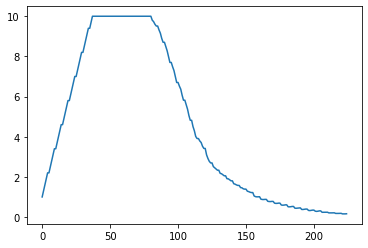

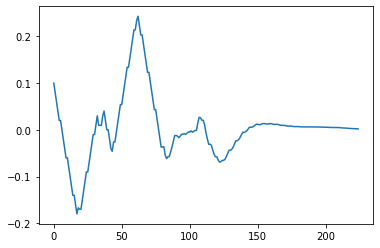

In [756]:
bot2 = multi_mpc_agent(2,np.array([0,0]),np.array([100,0]),0,10,0.7)
bot2.opt_traj()